In [1]:
# Python-3.8.18

In [2]:
!pip install plyfile PyMCubes trimesh open3d opencv-python matplotlib torch imageio imageio[pyav] imageio[ffmpeg]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 7.7 MB/s eta 0:00:0000:0100:01m


In [17]:
import os
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm, trange

from datetime import datetime


In [4]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2023-12-13 12:30:11--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2023-12-13 12:30:12--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  2.75MB/s    in 4.4s    

2023-12-13 12:30:17 (2.75 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



In [5]:
def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

    Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

    Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
    """
    # TESTED
    # Only works for the last dimension (dim=-1)
    dim = -1
    # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
    cumprod = torch.cumprod(tensor, dim)
    # "Roll" the elements along dimension 'dim' by 1 element.
    cumprod = torch.roll(cumprod, 1, dim)
    # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
    cumprod[..., 0] = 1.0

    return cumprod

def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
    r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
    Each element of the list (except possibly the last) has dimension `0` of length
    `chunksize`.
    """
    return [inputs[i : i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


def meshgrid_xy(
    tensor1: torch.Tensor, tensor2: torch.Tensor
) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)

def get_ray_bundle(
    height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor
):
    r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

    Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

    Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    """
    # TESTED
    ii, jj = meshgrid_xy(
        torch.arange(
            width, dtype=tform_cam2world.dtype, device=tform_cam2world.device
        ).to(tform_cam2world),
        torch.arange(
            height, dtype=tform_cam2world.dtype, device=tform_cam2world.device
        ),
    )
    directions = torch.stack(
        [
            (ii - width * 0.5) / focal_length,
            -(jj - height * 0.5) / focal_length,
            -torch.ones_like(ii),
        ],
        dim=-1,
    )
    ray_directions = torch.sum(
        directions[..., None, :] * tform_cam2world[:3, :3], dim=-1
    )
    ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
    return ray_origins, ray_directions

def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
    r"""Apply positional encoding to the input.

    Args:
        tensor (torch.Tensor): Input tensor to be positionally encoded.
        encoding_size (optional, int): Number of encoding functions used to compute
            a positional encoding (default: 6).
        include_input (optional, bool): Whether or not to include the input in the
            positional encoding (default: True).

    Returns:
    (torch.Tensor): Positional encoding of the input tensor.
    """
    # TESTED
    # Trivially, the input tensor is added to the positional encoding.
    encoding = [tensor] if include_input else []
    frequency_bands = None
    if log_sampling:
        frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
    else:
        frequency_bands = torch.linspace(
            2.0 ** 0.0,
            2.0 ** (num_encoding_functions - 1),
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )

    for freq in frequency_bands:
        for func in [torch.sin, torch.cos]:
            encoding.append(func(tensor * freq))

    # Special case, for no positional encoding
    if len(encoding) == 1:
        return encoding[0]
    else:
        return torch.cat(encoding, dim=-1)

In [6]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True,
) -> (torch.Tensor, torch.Tensor):
    r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
    variables indicate the bounds within which 3D points are to be sampled.

    Args:
        ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
          `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
        ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
          `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
        near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
          coordinate that is of interest/relevance).
        far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
          coordinate that is of interest/relevance).
        num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
          randomly, whilst trying to ensure "some form of" uniform spacing among them.
        randomize (optional, bool): Whether or not to randomize the sampling of query points.
          By default, this is set to `True`. If disabled (by setting to `False`), we sample
          uniformly spaced points along each ray in the "bundle".

    Returns:
        query_points (torch.Tensor): Query points along each ray
          (shape: :math:`(width, height, num_samples, 3)`).
        depth_values (torch.Tensor): Sampled depth values along each ray
          (shape: :math:`(num_samples)`).
    """
    # TESTED
    # shape: (num_samples)
    depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
    if randomize is True:
        # ray_origins: (width, height, 3)
        # noise_shape = (width, height, num_samples)
        noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
        # depth_values: (num_samples)
        depth_values = (
            depth_values
            + torch.rand(noise_shape).to(ray_origins)
            * (far_thresh - near_thresh)
            / num_samples
        )
    # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
    # query_points:  (width, height, num_samples, 3)
    query_points = (
        ray_origins[..., None, :]
        + ray_directions[..., None, :] * depth_values[..., :, None]
    )
    # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
    return query_points, depth_values




In [7]:
def render_volume_density(
    radiance_field: torch.Tensor, ray_origins: torch.Tensor, depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
    r"""Differentiably renders a radiance field, given the origin of each ray in the
    "bundle", and the sampled depth values along them.

    Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

    Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
    """
    # TESTED
    sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
    rgb = torch.sigmoid(radiance_field[..., :3])
    one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
    dists = torch.cat(
        (
            depth_values[..., 1:] - depth_values[..., :-1],
            one_e_10.expand(depth_values[..., :1].shape),
        ),
        dim=-1,
    )
    alpha = 1.0 - torch.exp(-sigma_a * dists)
    weights = alpha * cumprod_exclusive(1.0 - alpha + 1e-10)

    rgb_map = (weights[..., None] * rgb).sum(dim=-2)
    depth_map = (weights * depth_values).sum(dim=-1)
    acc_map = weights.sum(-1)

    return rgb_map, depth_map, acc_map



In [8]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(
    height,
    width,
    focal_length,
    tform_cam2world,
    near_thresh,
    far_thresh,
    depth_samples_per_ray,
    encoding_function,
    get_minibatches_function,
    chunksize,
    model,
    encoding_function_args,
):

    # Get the "bundle" of rays through all image pixels.
    ray_origins, ray_directions = get_ray_bundle(
        height, width, focal_length, tform_cam2world
    )

    # Sample query points along each ray
    query_points, depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
    )

    # "Flatten" the query points.
    flattened_query_points = query_points.reshape((-1, 3))

    # Encode the query points (default: positional encoding).
    encoded_points = encoding_function(flattened_query_points, encoding_function_args)

    # Split the encoded points into "chunks", run the model on all chunks, and
    # concatenate the results (to avoid out-of-memory issues).
    batches = get_minibatches_function(encoded_points, chunksize=chunksize)
    predictions = []
    for batch in batches:
        predictions.append(model(batch))
    radiance_field_flattened = torch.cat(predictions, dim=0)

    # "Unflatten" to obtain the radiance field.
    unflattened_shape = list(query_points.shape[:-1]) + [4]
    radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

    # Perform differentiable volume rendering to re-synthesize the RGB image.
    rgb_predicted, _, _ = render_volume_density(
        radiance_field, ray_origins, depth_values
    )

    return rgb_predicted

In [9]:
class VeryTinyNerfModel(torch.nn.Module):
    r"""Define a "very tiny" NeRF model comprising three fully connected layers.
    """

    def __init__(self, filter_size=128, num_encoding_functions=6):
        super(VeryTinyNerfModel, self).__init__()
        # Input layer (default: 39 -> 128)
        self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 4)
        self.layer3 = torch.nn.Linear(filter_size, 4)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [19]:
# def main():

# Determine device to run on (GPU vs CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Log directory
logdir = os.path.join("./", 'runs', datetime.now().isoformat())
os.makedirs(logdir, exist_ok=True)

"""
Load input images and poses
"""

data = np.load("tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.0
far_thresh = 6.0

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 10
# Specify encoding function.
encode = positional_encoding
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
# Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory (when using 8
# samples per ray).
chunksize = 4096

# Optimizer parameters
lr = 5e-3
num_iters = 5000

# Misc parameters
display_every = 100  # Number of iters after which stats are

weightpath = 'weight_smallnerf.tensor'


cuda


## Train

In [20]:

"""
Model
"""
model = VeryTinyNerfModel(filter_size=256, num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

for i in trange(num_iters):

    # Randomly pick an image as the target.
    target_img_idx = np.random.randint(images.shape[0])
    target_img = images[target_img_idx].to(device)
    target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

    # Run one iteration of TinyNeRF and get the rendered RGB image.
    rgb_predicted = run_one_iter_of_tinynerf(
        height,
        width,
        focal_length,
        target_tform_cam2world,
        near_thresh,
        far_thresh,
        depth_samples_per_ray,
        encode,
        get_minibatches,
        chunksize,
        model,
        num_encoding_functions,
    )

    # Compute mean-squared error between the predicted and target images. Backprop!
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Display images/plots/stats
    if i % display_every == 0 or i == num_iters - 1:
        # Render the held-out view
        rgb_predicted = run_one_iter_of_tinynerf(
            height,
            width,
            focal_length,
            testpose,
            near_thresh,
            far_thresh,
            depth_samples_per_ray,
            encode,
            get_minibatches,
            chunksize,
            model,
            num_encoding_functions,
        )
        loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
        tqdm.write("Loss: " + str(loss.item()))
        psnr = -10.0 * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        plt.imshow(rgb_predicted.detach().cpu().numpy())
        plt.savefig(os.path.join(logdir, str(i).zfill(6) + ".png"))
        plt.close("all")

        if i == num_iters - 1:
            plt.plot(iternums, psnrs)
            plt.savefig(os.path.join(logdir, "psnr.png"))
            plt.close("all")
        # plt.figure(figsize=(10, 4))
        # plt.subplot(121)
        # plt.imshow(rgb_predicted.detach().cpu().numpy())
        # plt.title(f"Iteration {i}")
        # plt.subplot(122)
        # plt.plot(iternums, psnrs)
        # plt.title("PSNR")
        # plt.show()

# save model
torch.save(model.state_dict(), weightpath)
print('Model saved: ', weightpath)

print("Done!")

  0%|          | 0/5000 [00:00<?, ?it/s]/home/ivan/miniconda3/envs/humannerf/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 1/5000 [00:00<49:16,  1.69it/s]

Loss: 0.1332242339849472


  2%|▏         | 103/5000 [00:04<04:00, 20.36it/s]

Loss: 0.02771405503153801


  4%|▍         | 202/5000 [00:09<03:56, 20.28it/s]

Loss: 0.10029058903455734


  6%|▌         | 304/5000 [00:13<03:40, 21.31it/s]

Loss: 0.10155501216650009


  8%|▊         | 403/5000 [00:17<03:46, 20.29it/s]

Loss: 0.07417762279510498


 10%|█         | 502/5000 [00:21<03:41, 20.35it/s]

Loss: 0.050808489322662354


 12%|█▏        | 601/5000 [00:26<03:52, 18.90it/s]

Loss: 0.10274959355592728


 14%|█▍        | 703/5000 [00:30<04:02, 17.69it/s]

Loss: 0.09797046333551407


 16%|█▌        | 802/5000 [00:35<03:29, 20.05it/s]

Loss: 0.09281214326620102


 18%|█▊        | 904/5000 [00:39<03:20, 20.46it/s]

Loss: 0.07026730477809906


 20%|██        | 1000/5000 [00:43<02:51, 23.30it/s]

Loss: 0.03906587138772011


 22%|██▏       | 1102/5000 [00:48<03:14, 20.05it/s]

Loss: 0.06605099886655807


 24%|██▍       | 1204/5000 [00:52<02:56, 21.54it/s]

Loss: 0.09570001810789108


 26%|██▌       | 1303/5000 [00:56<02:59, 20.56it/s]

Loss: 0.08691205829381943


 28%|██▊       | 1402/5000 [01:00<02:52, 20.91it/s]

Loss: 0.08726082742214203


 30%|███       | 1504/5000 [01:05<02:39, 21.97it/s]

Loss: 0.10941178351640701


 32%|███▏      | 1603/5000 [01:09<02:45, 20.52it/s]

Loss: 0.09310649335384369


 34%|███▍      | 1702/5000 [01:13<02:37, 21.00it/s]

Loss: 0.10710827261209488


 36%|███▌      | 1804/5000 [01:17<02:27, 21.67it/s]

Loss: 0.08372196555137634


 38%|███▊      | 1903/5000 [01:21<02:27, 20.96it/s]

Loss: 0.15366460382938385


 40%|████      | 2002/5000 [01:25<02:24, 20.79it/s]

Loss: 0.15063606202602386


 42%|████▏     | 2104/5000 [01:30<02:12, 21.80it/s]

Loss: 0.10393797606229782


 44%|████▍     | 2203/5000 [01:34<02:16, 20.51it/s]

Loss: 0.11710352450609207


 46%|████▌     | 2302/5000 [01:38<02:12, 20.34it/s]

Loss: 0.13566528260707855


 48%|████▊     | 2404/5000 [01:42<01:59, 21.72it/s]

Loss: 0.09916764497756958


 50%|█████     | 2503/5000 [01:46<01:59, 20.85it/s]

Loss: 0.11618241667747498


 52%|█████▏    | 2602/5000 [01:50<01:56, 20.67it/s]

Loss: 0.08834235370159149


 54%|█████▍    | 2704/5000 [01:55<01:46, 21.48it/s]

Loss: 0.07877787947654724


 56%|█████▌    | 2803/5000 [01:59<01:45, 20.83it/s]

Loss: 0.14781057834625244


 58%|█████▊    | 2902/5000 [02:03<01:51, 18.78it/s]

Loss: 0.11310603469610214


 60%|██████    | 3004/5000 [02:07<01:34, 21.20it/s]

Loss: 0.09716387838125229


 62%|██████▏   | 3103/5000 [02:11<01:30, 20.85it/s]

Loss: 0.10327917337417603


 64%|██████▍   | 3202/5000 [02:16<01:26, 20.70it/s]

Loss: 0.11121277511119843


 66%|██████▌   | 3304/5000 [02:20<01:17, 21.91it/s]

Loss: 0.08718906342983246


 68%|██████▊   | 3403/5000 [02:24<01:17, 20.67it/s]

Loss: 0.08613839000463486


 70%|███████   | 3502/5000 [02:28<01:14, 20.24it/s]

Loss: 0.060925137251615524


 72%|███████▏  | 3604/5000 [02:33<01:06, 20.92it/s]

Loss: 0.0974348783493042


 74%|███████▍  | 3703/5000 [02:37<01:03, 20.38it/s]

Loss: 0.07923818379640579


 76%|███████▌  | 3802/5000 [02:41<00:59, 20.07it/s]

Loss: 0.09579024463891983


 78%|███████▊  | 3904/5000 [02:46<00:55, 19.74it/s]

Loss: 0.07873690128326416


 80%|████████  | 4003/5000 [02:50<00:53, 18.58it/s]

Loss: 0.10829853266477585


 82%|████████▏ | 4102/5000 [02:54<00:46, 19.48it/s]

Loss: 0.06432471424341202


 84%|████████▍ | 4203/5000 [02:59<00:43, 18.12it/s]

Loss: 0.09202298521995544


 86%|████████▌ | 4302/5000 [03:03<00:35, 19.53it/s]

Loss: 0.0761677548289299


 88%|████████▊ | 4404/5000 [03:07<00:27, 21.43it/s]

Loss: 0.07007340341806412


 90%|█████████ | 4503/5000 [03:12<00:25, 19.84it/s]

Loss: 0.08827829360961914


 92%|█████████▏| 4602/5000 [03:16<00:19, 20.45it/s]

Loss: 0.08249015361070633


 94%|█████████▍| 4704/5000 [03:20<00:13, 21.38it/s]

Loss: 0.13071785867214203


 96%|█████████▌| 4803/5000 [03:24<00:10, 19.42it/s]

Loss: 0.09757960587739944


 98%|█████████▊| 4902/5000 [03:29<00:04, 20.14it/s]

Loss: 0.14870458841323853


100%|██████████| 5000/5000 [03:33<00:00, 23.42it/s]

Loss: 0.05760730057954788
Model saved:  weight_smallnerf.tensor
Done!


## Render 360 video 
insparation:
https://github.com/kwea123/nerf_pl

In [21]:
model = VeryTinyNerfModel(filter_size=256, num_encoding_functions=num_encoding_functions)
model.load_state_dict(torch.load(weightpath))
model = model.to(device)

In [22]:
# Render 360

trans_t = lambda t : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=torch.float32)

rot_phi = lambda phi : torch.tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=torch.float32)

rot_theta = lambda th : torch.tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=torch.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180. * torch.pi) @ c2w
    c2w = rot_theta(theta/180.*torch.pi) @ c2w
    c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]).float() @ c2w
    return c2w


In [23]:
frames = []
with torch.no_grad():
    for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
        c2w = pose_spherical(th, -30., 4.)
        # Get the "bundle" of rays through all image pixels.
        ray_origins, ray_directions = get_ray_bundle(
            height, width, focal_length, c2w.to(device)
        )

        # Sample query points along each ray
        query_points, depth_values = compute_query_points_from_rays(
            ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
        )

        # "Flatten" the query points.
        flattened_query_points = query_points.reshape((-1, 3))

        # Encode the query points (default: positional encoding).
        encoded_points = encode(flattened_query_points, num_encoding_functions)

        # Split the encoded points into "chunks", run the model on all chunks, and
        # concatenate the results (to avoid out-of-memory issues).
        batches = get_minibatches(encoded_points, chunksize=chunksize)
        predictions = []
        for batch in batches:
            predictions.append(model(batch))
        radiance_field_flattened = torch.cat(predictions, dim=0)

        # "Unflatten" to obtain the radiance field.
        unflattened_shape = list(query_points.shape[:-1]) + [4]
        radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

        # Perform differentiable volume rendering to re-synthesize the RGB image.
        rgb_predicted, _, _ = render_volume_density(
            radiance_field, ray_origins, depth_values
            )
        frames += [np.array(rgb_predicted.cpu()*255).astype(np.uint8)]


100%|██████████| 120/120 [00:02<00:00, 55.60it/s]


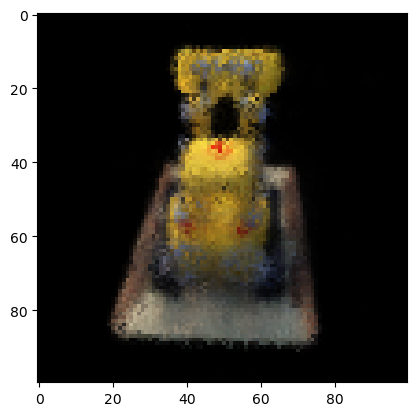

In [24]:
plt.imshow(rgb_predicted.cpu())

In [25]:
import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (100, 100) to (112, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x565bb40] Warning: data is not aligned! This can lead to a speed loss


## 3D model rendering

In [26]:
import mcubes
import trimesh

chunk = 1024*32

In [27]:
model = VeryTinyNerfModel(filter_size=256, num_encoding_functions=num_encoding_functions)
model.load_state_dict(torch.load(weightpath))
model = model.to(device)

In [28]:
### Tune these parameters until the whole object lies tightly in range with little noise ###
N = 100 #128 # controls the resolution, set this number small here because we're only finding
        # good ranges here, not yet for mesh reconstruction; we can set this number high
        # when it comes to final reconstruction.
xmin, xmax = -1.2, 1.2 # left/right range
ymin, ymax = -1.2, 1.2 # forward/backward range
zmin, zmax = -0.2, 2.2 # up/down range
## Attention! the ranges MUST have the same length!
sigma_threshold = 5. # controls the noise (lower=maybe more noise; higher=some mesh might be missing)
############################################################################################

x = np.linspace(xmin, xmax, N)
y = np.linspace(ymin, ymax, N)
z = np.linspace(zmin, zmax, N)

xyz_ = torch.tensor(np.stack(np.meshgrid(x, y, z), -1).reshape(-1, 3)).float()
dir_ = torch.zeros_like(xyz_)

In [29]:
with torch.no_grad():
    B = xyz_.shape[0]
    out_chunks = []
    for i in range(0, B, chunk):
        encoded_points = encode(xyz_[i:i+chunk].to(device), num_encoding_functions)
        out_chunks += [model(encoded_points)]

    rgbsigma = torch.cat(out_chunks, 0)


In [30]:
sigma = rgbsigma[:, -1].cpu().numpy()
sigma = np.maximum(sigma, 0)
sigma = sigma.reshape(N, N, N)


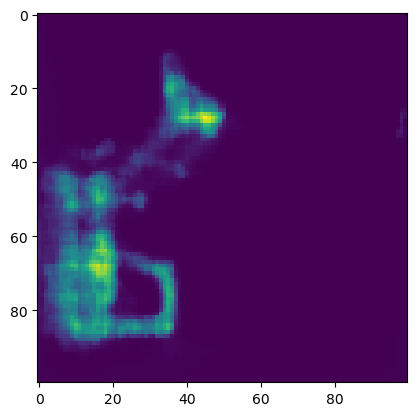

In [31]:
# plt.figure()
# plt.imshow(sigma[50])
plt.figure()
plt.imshow(sigma[:,55])
# plt.figure()
# plt.imshow(sigma[:,:,50])


In [32]:
# The below lines are for visualization, COMMENT OUT once you find the best range and increase N!
vertices, triangles = mcubes.marching_cubes(sigma, sigma_threshold)
mesh = trimesh.Trimesh(vertices/N, triangles)
mesh.show()

In [33]:
scene_name = 'mesh_pred'
mesh.export(f"{scene_name}.ply")


b'ply\nformat binary_little_endian 1.0\ncomment https://github.com/mikedh/trimesh\nelement vertex 19170\nproperty float x\nproperty float y\nproperty float z\nelement face 37834\nproperty list uchar int vertex_indices\nend_header\n\x07*\xc5=33\xb3>33\xb3>\xcd\xcc\xcc=Y8\xaf>33\xb3>\xcd\xcc\xcc=33\xb3>k\xf8\xb0>0h\xc5=33\xb3>\xecQ\xb8>\xcd\xcc\xcc=\xa7\xff\xae>\xecQ\xb8>\xcd\xcc\xcc=33\xb3>\xe0I\xba>fe\xc8=\xecQ\xb8>33\xb3>\xcd\xcc\xcc=\xecQ\xb8>\x05\xe8\xb1>C>\xca=\xecQ\xb8>\xecQ\xb8>\xcd\xcc\xcc=\xecQ\xb8>M\x1a\xb9>\xcd\xcc\xcc=m\x10\xba>33\xb3>\xcd\xcc\xcc=\x14T\xb9>\xecQ\xb8>\xb7\xe6\xcb=\xcd\xcc\xcc>33\xb3>\xcd\xcc\xcc=\xf9`\xcc>33\xb3>\xcd\xcc\xcc=\xcd\xcc\xcc>\x06\xe3\xb2>\xcd\xcc\xcc=\xcd\xcc\xcc>\x9f\xe0\xb3>\xcd\xcc\xcc=\x00\xed\xcd>33\xb3>%\xf7\xca=\n\xd7#?33\xb3>\xcd\xcc\xcc=\xedw"?33\xb3>\xcd\xcc\xcc=\n\xd7#?\x1a\x97\xb2>\xcd\xcc\xcc=\n\xd7#?\x02\xd5\xb4>\xcd\xcc\xcc=\x00\x9e$?33\xb3>\xba\x89\xce={\x14\xae>33\xb3>\xaeG\xe1=\xf5\xc3\xa9>33\xb3>\xaeG\xe1={\x14\xae>\x8a>\xaf>\

## Color mesh

In [34]:
from plyfile import PlyData, PlyElement
import open3d
import cv2


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [35]:
vertices_ = (vertices/N)#.astype(np.float32)
## invert x and y coordinates (WHY? maybe because of the marching cubes algo)
x_ = (ymax-ymin) * vertices_[:, 1] + ymin
y_ = (xmax-xmin) * vertices_[:, 0] + xmin
z_ = (zmax-zmin) * vertices_[:, 2] + zmin
vertices_[:, 0] = x_
vertices_[:, 1] = y_
vertices_[:, 2] = z_

face = np.empty(len(triangles), dtype=[('vertex_indices', 'i4', (3,))])
face['vertex_indices'] = triangles

N_vertices = vertices.shape[0]
vertex_all = np.empty(N_vertices, dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
vertex_all['x'] = x_.astype('f4')
vertex_all['y'] = y_.astype('f4')
vertex_all['z'] = z_.astype('f4')

ply = PlyData([PlyElement.describe(vertex_all, 'vertex'), 
               PlyElement.describe(face, 'face')], text=False)
ply.write(f"{scene_name}.ply")

In [36]:
# remove noise in the mesh by keeping only the biggest cluster
print('Removing noise ...')
mesh = open3d.io.read_triangle_mesh(f"{scene_name}.ply")
idxs, count, _ = mesh.cluster_connected_triangles()
max_cluster_idx = np.argmax(count)
triangles_to_remove = [i for i in range(len(face)) if idxs[i] != max_cluster_idx]
mesh.remove_triangles_by_index(triangles_to_remove)
mesh.remove_unreferenced_vertices()
print(f'Mesh has {len(mesh.vertices)/1e6:.2f} M vertices and {len(mesh.triangles)/1e6:.2f} M faces.')

vertices_ = np.asarray(mesh.vertices).astype(np.float32)
triangles = np.asarray(mesh.triangles)

Removing noise ...
Mesh has 0.02 M vertices and 0.04 M faces.


In [37]:
# m = trimesh.Trimesh(vertices_/N, triangles)
# m.show()

In [38]:
# perform color prediction
# Step 0. define constants (image width, height and intrinsics)
W, H = 100, 100
K = torch.tensor([[focal_length, 0, width/2],
                [0, focal_length, height/2],
                [0,             0,   1]]).float()

In [39]:
# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]

# Step 1. transform vertices into world coordinate
N_vertices = len(vertices_)
vertices_homo = np.concatenate([vertices_, np.ones((N_vertices, 1))], 1) # (N, 4)

## buffers to store the final averaged color
non_occluded_sum = np.zeros((N_vertices, 1))
v_color_sum = np.zeros((N_vertices, 3))

In [40]:
def get_results_for_color(model, rays_o, rays_d, near, far, chunk, depth_samples_per_ray):
    # Get the "bundle" of rays through all image pixels.
    # ray_origins, ray_directions = get_ray_bundle(
    #     height, width, focal_length, tform_cam2world
    # )
    ray_origins, ray_directions = rays_o, rays_d
    near_thresh, far_thresh = near,far

    # Sample query points along each ray
    query_points, depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
    )

    # "Flatten" the query points.
    flattened_query_points = query_points.reshape((-1, 3))

    # Encode the query points (default: positional encoding).
    encoded_points = encode(flattened_query_points, num_encoding_functions)

    # Split the encoded points into "chunks", run the model on all chunks, and
    # concatenate the results (to avoid out-of-memory issues).
    batches = get_minibatches(encoded_points, chunksize=chunk)
    predictions = []
    for batch in batches:
        predictions.append(model(batch))
    radiance_field_flattened = torch.cat(predictions, dim=0)

    # "Unflatten" to obtain the radiance field.
    unflattened_shape = list(query_points.shape[:-1]) + [4]
    radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

    # Perform differentiable volume rendering to re-synthesize the RGB image.
    rgb_map, depth_map, acc_map = render_volume_density(
        radiance_field, ray_origins, depth_values
    )

    return rgb_map, depth_map, acc_map


In [41]:
mesh.compute_vertex_normals()
rays_d = torch.FloatTensor(np.asarray(mesh.vertex_normals))
near = near_thresh * torch.ones_like(rays_d[:, :1])
far = far_thresh * torch.ones_like(rays_d[:, :1])
rays_o = torch.tensor(vertices_) - rays_d * near #* near_t

with torch.no_grad():
    rgb_map, depth_map, acc_map = get_results_for_color(
        model, rays_o.to(device), rays_d.to(device), near_thresh, far_thresh, chunk, depth_samples_per_ray)

In [42]:
v_colors = rgb_map.cpu().numpy() * 255.0
v_colors = v_colors.astype(np.uint8)

vertex_all = np.empty(N_vertices, dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')])
vertex_all['x'] = vertices_[:,0].astype('f4')
vertex_all['y'] = vertices_[:,1].astype('f4')
vertex_all['z'] = vertices_[:,2].astype('f4')
vertex_all['red'] = v_colors[:,0].astype('u1')
vertex_all['green'] = v_colors[:,1].astype('u1')
vertex_all['blue'] = v_colors[:,2].astype('u1')

face = np.empty(len(triangles), dtype=[('vertex_indices', 'i4', (3,))])
face['vertex_indices'] = triangles

ply = PlyData([PlyElement.describe(vertex_all, 'vertex'), 
               PlyElement.describe(face, 'face')], text=False)
ply.write(f"{scene_name}.ply")